In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_crossentropy

import warnings
warnings.filterwarnings(action = 'ignore')

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
#df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

In [2]:
df = pd.read_csv('./train.csv')

In [3]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [5]:
df.shape

(7613, 5)

Training dataset has 7,613 rows and 5 columns.

In [6]:
df.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
df.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [9]:
df.duplicated().sum()

0

There are no duplicate values in that dataset.

In [10]:
(df.isnull().sum() / df.shape[0]) * 100

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

In [11]:
df[~(df['keyword'].isnull())]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0


In [12]:
df['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [13]:
df.groupby('keyword')['target'].value_counts()

keyword     target
ablaze      0         23
            1         13
accident    1         24
            0         11
aftershock  0         34
                      ..
wreck       0         30
            1          7
wreckage    1         39
wrecked     0         36
            1          3
Name: target, Length: 438, dtype: int64

In [14]:
df['tweet'] = np.where((df['keyword'].isnull()), df['text'], (df['keyword'] + ' ' + df['text']))

In [15]:
df[~df['keyword'].isnull()]['tweet']

31      ablaze @bbcmtd Wholesale Markets ablaze http:/...
32      ablaze We always try to bring the heavy. #meta...
33      ablaze #AFRICANBAZE: Breaking news:Nigeria fla...
34              ablaze Crying out for more! Set me ablaze
35      ablaze On plus side LOOK AT THE SKY LAST NIGHT...
                              ...                        
7578    wrecked @jt_ruff23 @cameronhacker and I wrecke...
7579    wrecked Three days off from work and they've p...
7580    wrecked #FX #forex #trading Cramer: Iger's 3 w...
7581    wrecked @engineshed Great atmosphere at the Br...
7582    wrecked Cramer: Iger's 3 words that wrecked Di...
Name: tweet, Length: 7552, dtype: object

In [16]:
to_drop = ['id', 'keyword', 'location', 'text']
df.drop(columns = to_drop, axis = 1, inplace=True)

In [17]:
df.isnull().sum()

target    0
tweet     0
dtype: int64

In [18]:
df.head()

,target,tweet
0,1,Our Deeds are the Reason of this #earthquake M...
1,1,Forest fire near La Ronge Sask. Canada
2,1,All residents asked to 'shelter in place' are ...
3,1,"13,000 people receive #wildfires evacuation or..."
4,1,Just got sent this photo from Ruby #Alaska as ...


In [19]:
X = df['tweet']
y = df['target']

In [20]:
X

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: tweet, Length: 7613, dtype: object

In [21]:
y

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

In [22]:
X = X.values.flatten()
X

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ...,
       'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ',
       'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'],
      dtype=object)

In [23]:
y.value_counts(normalize = True) * 100

0    57.034021
1    42.965979
Name: target, dtype: float64

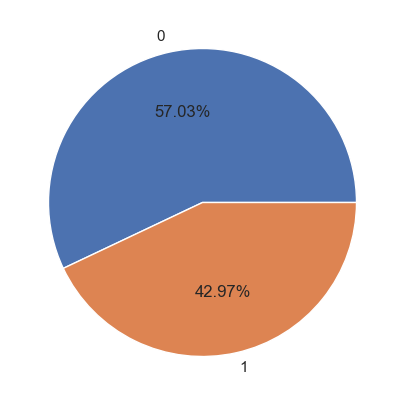

In [24]:
sns.set()
plt.figure(figsize = (5, 5))
plt.pie(x = ((y.value_counts(normalize = True) * 100).values), labels = ((y.value_counts(normalize = True) * 100).index), autopct= '%1.2f%%')
plt.show()

In [25]:
ps = PorterStemmer()
corpus = []

for i in range(0, len(X)):
    text = re.sub('a-zA-Z', ' ', X[i])
    text = text.lower()
    text = text.split()
    text = [ps.stem(word) for word in text if not word in stopwords.words('english')]
    text = ' '.join(text)
    corpus.append(text)
    print(f'status : {i + 1}')

status : 1
status : 2
status : 3
status : 4
status : 5
status : 6
status : 7
status : 8
status : 9
status : 10
status : 11
status : 12
status : 13
status : 14
status : 15
status : 16
status : 17
status : 18
status : 19
status : 20
status : 21
status : 22
status : 23
status : 24
status : 25
status : 26
status : 27
status : 28
status : 29
status : 30
status : 31
status : 32
status : 33
status : 34
status : 35
status : 36
status : 37
status : 38
status : 39
status : 40
status : 41
status : 42
status : 43
status : 44
status : 45
status : 46
status : 47
status : 48
status : 49
status : 50
status : 51
status : 52
status : 53
status : 54
status : 55
status : 56
status : 57
status : 58
status : 59
status : 60
status : 61
status : 62
status : 63
status : 64
status : 65
status : 66
status : 67
status : 68
status : 69
status : 70
status : 71
status : 72
status : 73
status : 74
status : 75
status : 76
status : 77
status : 78
status : 79
status : 80
status : 81
status : 82
status : 83
status : 84
s

status : 717
status : 718
status : 719
status : 720
status : 721
status : 722
status : 723
status : 724
status : 725
status : 726
status : 727
status : 728
status : 729
status : 730
status : 731
status : 732
status : 733
status : 734
status : 735
status : 736
status : 737
status : 738
status : 739
status : 740
status : 741
status : 742
status : 743
status : 744
status : 745
status : 746
status : 747
status : 748
status : 749
status : 750
status : 751
status : 752
status : 753
status : 754
status : 755
status : 756
status : 757
status : 758
status : 759
status : 760
status : 761
status : 762
status : 763
status : 764
status : 765
status : 766
status : 767
status : 768
status : 769
status : 770
status : 771
status : 772
status : 773
status : 774
status : 775
status : 776
status : 777
status : 778
status : 779
status : 780
status : 781
status : 782
status : 783
status : 784
status : 785
status : 786
status : 787
status : 788
status : 789
status : 790
status : 791
status : 792
status : 793

status : 1329
status : 1330
status : 1331
status : 1332
status : 1333
status : 1334
status : 1335
status : 1336
status : 1337
status : 1338
status : 1339
status : 1340
status : 1341
status : 1342
status : 1343
status : 1344
status : 1345
status : 1346
status : 1347
status : 1348
status : 1349
status : 1350
status : 1351
status : 1352
status : 1353
status : 1354
status : 1355
status : 1356
status : 1357
status : 1358
status : 1359
status : 1360
status : 1361
status : 1362
status : 1363
status : 1364
status : 1365
status : 1366
status : 1367
status : 1368
status : 1369
status : 1370
status : 1371
status : 1372
status : 1373
status : 1374
status : 1375
status : 1376
status : 1377
status : 1378
status : 1379
status : 1380
status : 1381
status : 1382
status : 1383
status : 1384
status : 1385
status : 1386
status : 1387
status : 1388
status : 1389
status : 1390
status : 1391
status : 1392
status : 1393
status : 1394
status : 1395
status : 1396
status : 1397
status : 1398
status : 1399
status

status : 1919
status : 1920
status : 1921
status : 1922
status : 1923
status : 1924
status : 1925
status : 1926
status : 1927
status : 1928
status : 1929
status : 1930
status : 1931
status : 1932
status : 1933
status : 1934
status : 1935
status : 1936
status : 1937
status : 1938
status : 1939
status : 1940
status : 1941
status : 1942
status : 1943
status : 1944
status : 1945
status : 1946
status : 1947
status : 1948
status : 1949
status : 1950
status : 1951
status : 1952
status : 1953
status : 1954
status : 1955
status : 1956
status : 1957
status : 1958
status : 1959
status : 1960
status : 1961
status : 1962
status : 1963
status : 1964
status : 1965
status : 1966
status : 1967
status : 1968
status : 1969
status : 1970
status : 1971
status : 1972
status : 1973
status : 1974
status : 1975
status : 1976
status : 1977
status : 1978
status : 1979
status : 1980
status : 1981
status : 1982
status : 1983
status : 1984
status : 1985
status : 1986
status : 1987
status : 1988
status : 1989
status

status : 2558
status : 2559
status : 2560
status : 2561
status : 2562
status : 2563
status : 2564
status : 2565
status : 2566
status : 2567
status : 2568
status : 2569
status : 2570
status : 2571
status : 2572
status : 2573
status : 2574
status : 2575
status : 2576
status : 2577
status : 2578
status : 2579
status : 2580
status : 2581
status : 2582
status : 2583
status : 2584
status : 2585
status : 2586
status : 2587
status : 2588
status : 2589
status : 2590
status : 2591
status : 2592
status : 2593
status : 2594
status : 2595
status : 2596
status : 2597
status : 2598
status : 2599
status : 2600
status : 2601
status : 2602
status : 2603
status : 2604
status : 2605
status : 2606
status : 2607
status : 2608
status : 2609
status : 2610
status : 2611
status : 2612
status : 2613
status : 2614
status : 2615
status : 2616
status : 2617
status : 2618
status : 2619
status : 2620
status : 2621
status : 2622
status : 2623
status : 2624
status : 2625
status : 2626
status : 2627
status : 2628
status

status : 3149
status : 3150
status : 3151
status : 3152
status : 3153
status : 3154
status : 3155
status : 3156
status : 3157
status : 3158
status : 3159
status : 3160
status : 3161
status : 3162
status : 3163
status : 3164
status : 3165
status : 3166
status : 3167
status : 3168
status : 3169
status : 3170
status : 3171
status : 3172
status : 3173
status : 3174
status : 3175
status : 3176
status : 3177
status : 3178
status : 3179
status : 3180
status : 3181
status : 3182
status : 3183
status : 3184
status : 3185
status : 3186
status : 3187
status : 3188
status : 3189
status : 3190
status : 3191
status : 3192
status : 3193
status : 3194
status : 3195
status : 3196
status : 3197
status : 3198
status : 3199
status : 3200
status : 3201
status : 3202
status : 3203
status : 3204
status : 3205
status : 3206
status : 3207
status : 3208
status : 3209
status : 3210
status : 3211
status : 3212
status : 3213
status : 3214
status : 3215
status : 3216
status : 3217
status : 3218
status : 3219
status

status : 3748
status : 3749
status : 3750
status : 3751
status : 3752
status : 3753
status : 3754
status : 3755
status : 3756
status : 3757
status : 3758
status : 3759
status : 3760
status : 3761
status : 3762
status : 3763
status : 3764
status : 3765
status : 3766
status : 3767
status : 3768
status : 3769
status : 3770
status : 3771
status : 3772
status : 3773
status : 3774
status : 3775
status : 3776
status : 3777
status : 3778
status : 3779
status : 3780
status : 3781
status : 3782
status : 3783
status : 3784
status : 3785
status : 3786
status : 3787
status : 3788
status : 3789
status : 3790
status : 3791
status : 3792
status : 3793
status : 3794
status : 3795
status : 3796
status : 3797
status : 3798
status : 3799
status : 3800
status : 3801
status : 3802
status : 3803
status : 3804
status : 3805
status : 3806
status : 3807
status : 3808
status : 3809
status : 3810
status : 3811
status : 3812
status : 3813
status : 3814
status : 3815
status : 3816
status : 3817
status : 3818
status

status : 4341
status : 4342
status : 4343
status : 4344
status : 4345
status : 4346
status : 4347
status : 4348
status : 4349
status : 4350
status : 4351
status : 4352
status : 4353
status : 4354
status : 4355
status : 4356
status : 4357
status : 4358
status : 4359
status : 4360
status : 4361
status : 4362
status : 4363
status : 4364
status : 4365
status : 4366
status : 4367
status : 4368
status : 4369
status : 4370
status : 4371
status : 4372
status : 4373
status : 4374
status : 4375
status : 4376
status : 4377
status : 4378
status : 4379
status : 4380
status : 4381
status : 4382
status : 4383
status : 4384
status : 4385
status : 4386
status : 4387
status : 4388
status : 4389
status : 4390
status : 4391
status : 4392
status : 4393
status : 4394
status : 4395
status : 4396
status : 4397
status : 4398
status : 4399
status : 4400
status : 4401
status : 4402
status : 4403
status : 4404
status : 4405
status : 4406
status : 4407
status : 4408
status : 4409
status : 4410
status : 4411
status

status : 5007
status : 5008
status : 5009
status : 5010
status : 5011
status : 5012
status : 5013
status : 5014
status : 5015
status : 5016
status : 5017
status : 5018
status : 5019
status : 5020
status : 5021
status : 5022
status : 5023
status : 5024
status : 5025
status : 5026
status : 5027
status : 5028
status : 5029
status : 5030
status : 5031
status : 5032
status : 5033
status : 5034
status : 5035
status : 5036
status : 5037
status : 5038
status : 5039
status : 5040
status : 5041
status : 5042
status : 5043
status : 5044
status : 5045
status : 5046
status : 5047
status : 5048
status : 5049
status : 5050
status : 5051
status : 5052
status : 5053
status : 5054
status : 5055
status : 5056
status : 5057
status : 5058
status : 5059
status : 5060
status : 5061
status : 5062
status : 5063
status : 5064
status : 5065
status : 5066
status : 5067
status : 5068
status : 5069
status : 5070
status : 5071
status : 5072
status : 5073
status : 5074
status : 5075
status : 5076
status : 5077
status

status : 5601
status : 5602
status : 5603
status : 5604
status : 5605
status : 5606
status : 5607
status : 5608
status : 5609
status : 5610
status : 5611
status : 5612
status : 5613
status : 5614
status : 5615
status : 5616
status : 5617
status : 5618
status : 5619
status : 5620
status : 5621
status : 5622
status : 5623
status : 5624
status : 5625
status : 5626
status : 5627
status : 5628
status : 5629
status : 5630
status : 5631
status : 5632
status : 5633
status : 5634
status : 5635
status : 5636
status : 5637
status : 5638
status : 5639
status : 5640
status : 5641
status : 5642
status : 5643
status : 5644
status : 5645
status : 5646
status : 5647
status : 5648
status : 5649
status : 5650
status : 5651
status : 5652
status : 5653
status : 5654
status : 5655
status : 5656
status : 5657
status : 5658
status : 5659
status : 5660
status : 5661
status : 5662
status : 5663
status : 5664
status : 5665
status : 5666
status : 5667
status : 5668
status : 5669
status : 5670
status : 5671
status

status : 6228
status : 6229
status : 6230
status : 6231
status : 6232
status : 6233
status : 6234
status : 6235
status : 6236
status : 6237
status : 6238
status : 6239
status : 6240
status : 6241
status : 6242
status : 6243
status : 6244
status : 6245
status : 6246
status : 6247
status : 6248
status : 6249
status : 6250
status : 6251
status : 6252
status : 6253
status : 6254
status : 6255
status : 6256
status : 6257
status : 6258
status : 6259
status : 6260
status : 6261
status : 6262
status : 6263
status : 6264
status : 6265
status : 6266
status : 6267
status : 6268
status : 6269
status : 6270
status : 6271
status : 6272
status : 6273
status : 6274
status : 6275
status : 6276
status : 6277
status : 6278
status : 6279
status : 6280
status : 6281
status : 6282
status : 6283
status : 6284
status : 6285
status : 6286
status : 6287
status : 6288
status : 6289
status : 6290
status : 6291
status : 6292
status : 6293
status : 6294
status : 6295
status : 6296
status : 6297
status : 6298
status

status : 6817
status : 6818
status : 6819
status : 6820
status : 6821
status : 6822
status : 6823
status : 6824
status : 6825
status : 6826
status : 6827
status : 6828
status : 6829
status : 6830
status : 6831
status : 6832
status : 6833
status : 6834
status : 6835
status : 6836
status : 6837
status : 6838
status : 6839
status : 6840
status : 6841
status : 6842
status : 6843
status : 6844
status : 6845
status : 6846
status : 6847
status : 6848
status : 6849
status : 6850
status : 6851
status : 6852
status : 6853
status : 6854
status : 6855
status : 6856
status : 6857
status : 6858
status : 6859
status : 6860
status : 6861
status : 6862
status : 6863
status : 6864
status : 6865
status : 6866
status : 6867
status : 6868
status : 6869
status : 6870
status : 6871
status : 6872
status : 6873
status : 6874
status : 6875
status : 6876
status : 6877
status : 6878
status : 6879
status : 6880
status : 6881
status : 6882
status : 6883
status : 6884
status : 6885
status : 6886
status : 6887
status

status : 7403
status : 7404
status : 7405
status : 7406
status : 7407
status : 7408
status : 7409
status : 7410
status : 7411
status : 7412
status : 7413
status : 7414
status : 7415
status : 7416
status : 7417
status : 7418
status : 7419
status : 7420
status : 7421
status : 7422
status : 7423
status : 7424
status : 7425
status : 7426
status : 7427
status : 7428
status : 7429
status : 7430
status : 7431
status : 7432
status : 7433
status : 7434
status : 7435
status : 7436
status : 7437
status : 7438
status : 7439
status : 7440
status : 7441
status : 7442
status : 7443
status : 7444
status : 7445
status : 7446
status : 7447
status : 7448
status : 7449
status : 7450
status : 7451
status : 7452
status : 7453
status : 7454
status : 7455
status : 7456
status : 7457
status : 7458
status : 7459
status : 7460
status : 7461
status : 7462
status : 7463
status : 7464
status : 7465
status : 7466
status : 7467
status : 7468
status : 7469
status : 7470
status : 7471
status : 7472
status : 7473
status

In [26]:
corpus

['deed reason #earthquak may allah forgiv us',
 'forest fire near la rong sask. canada',
 "resid ask 'shelter place' notifi officers. evacu shelter place order expect",
 '13,000 peopl receiv #wildfir evacu order california',
 'got sent photo rubi #alaska smoke #wildfir pour school',
 '#rockyfir updat => california hwy. 20 close direct due lake counti fire - #cafir #wildfir',
 '#flood #disast heavi rain caus flash flood street manitou, colorado spring area',
 "i'm top hill see fire woods...",
 "there' emerg evacu happen build across street",
 "i'm afraid tornado come area...",
 'three peopl die heat wave far',
 'haha south tampa get flood hah- wait second live south tampa gonna gonna fvck #flood',
 "#rain #flood #florida #tampabay #tampa 18 19 days. i'v lost count",
 '#flood bago myanmar #we arriv bago',
 'damag school bu 80 multi car crash #break',
 "what' man?",
 'love fruit',
 'summer love',
 'car fast',
 'goooooooaaaaaal!!!!!!',
 'ridiculous....',
 'london cool ;)',
 'love ski',
 'w

In [27]:
print(f"Before preprocessing : {X[0]}")
print(f"After preprocessing : {corpus[0]}")

Before preprocessing : Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
After preprocessing : deed reason #earthquak may allah forgiv us


In [28]:
voc_size = 5000
one_hot_re = [one_hot(text, n = voc_size) for text in corpus]
one_hot_re

[[1882, 4671, 4717, 4574, 2968, 1770, 2282],
 [3775, 1119, 4484, 3080, 2279, 1213, 4221],
 [3992, 3060, 1737, 3313, 3831, 3004, 1166, 2196, 1058, 3850, 3684],
 [821, 3460, 1383, 4841, 4698, 1166, 3850, 3063],
 [2640, 722, 3356, 1128, 1918, 2971, 4698, 4269, 241],
 [4671, 685, 3063, 1175, 2496, 1361, 1367, 2524, 4120, 1969, 1119, 4704, 4698],
 [263, 2330, 3439, 1859, 4716, 4580, 263, 272, 662, 4147, 3947, 2919],
 [4680, 3246, 4675, 1182, 1119, 515],
 [1414, 3067, 1166, 899, 1834, 4802, 272],
 [4680, 686, 3524, 3340, 2919],
 [3981, 1383, 331, 417, 1715, 3565],
 [3247,
  1770,
  2756,
  1627,
  263,
  4420,
  2453,
  1549,
  3268,
  1770,
  2756,
  3431,
  3431,
  1402,
  263],
 [1859, 263, 1359, 1794, 2756, 4866, 1806, 2737, 4895, 1019, 1506],
 [263, 4073, 3101, 1684, 2392, 4073],
 [768, 241, 2746, 1733, 2466, 701, 665, 2050],
 [4362, 4420],
 [552, 3255],
 [4411, 552],
 [701, 2706],
 [2137],
 [3651],
 [2834, 1518],
 [552, 1147],
 [1024, 2379],
 [1300],
 [1445, 2447, 3144, 3059, 247],
 [3

In [29]:
max_len = 0
lent = []

for i in range(0, len(one_hot_re)):
    lent.append(len(one_hot_re[i]))
    
max_len = max(lent)
print(f'max lenth : {max_len}')

max lenth : 29


In [30]:
text_with_pad = pad_sequences(sequences=one_hot_re, padding= 'pre', maxlen = max_len)
text_with_pad

array([[   0,    0,    0, ..., 2968, 1770, 2282],
       [   0,    0,    0, ..., 2279, 1213, 4221],
       [   0,    0,    0, ..., 1058, 3850, 3684],
       ...,
       [   0,    0,    0, ..., 1532, 3163, 1499],
       [   0,    0,    0, ...,  146, 2800, 3624],
       [   0,    0,    0, ..., 1532, 3163, 3295]])

In [31]:
out_cat = len(y.unique())
out_cat

2

In [32]:
X = np.array(text_with_pad)
y = np.array(y)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4, train_size= 0.8, shuffle= True)

In [34]:
print(f"X_train has : {X_train.shape}")
print(f"y_train has : {y_train.shape}")
print(f"X_test has : {X_test.shape}")
print(f"y_train has : {y_test.shape}")

X_train has : (6090, 29)
y_train has : (6090,)
X_test has : (1523, 29)
y_train has : (1523,)


In [35]:
model1 = Sequential([
    Embedding(input_dim=voc_size, output_dim=40, input_length= max_len),
    LSTM(units= 128),
    Dense(units= 1, activation= 'relu')
])

In [37]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 29, 40)            200000    
                                                                 
 lstm (LSTM)                 (None, 128)               86528     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 286657 (1.09 MB)
Trainable params: 286657 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
model1.compile(optimizer= Adam(), 
             loss = binary_crossentropy,
             metrics= ['acc'])

In [39]:
model1_hist = model1.fit(x = X_train, 
                      y = y_train,
                      validation_data= (X_test, y_test),
                      epochs= 5,
                      batch_size = 50)

Epoch 1/5
122/122 [==============================] - 6s 27ms/step - loss: 0.6741 - acc: 0.6780 - val_loss: 0.6664 - val_acc: 0.7728
Epoch 2/5
122/122 [==============================] - 3s 25ms/step - loss: 0.4840 - acc: 0.8345 - val_loss: 0.8522 - val_acc: 0.7669
Epoch 3/5
122/122 [==============================] - 3s 24ms/step - loss: 0.4693 - acc: 0.8284 - val_loss: 1.0341 - val_acc: 0.7623
Epoch 4/5
122/122 [==============================] - 3s 24ms/step - loss: 0.3260 - acc: 0.9090 - val_loss: 1.4861 - val_acc: 0.7577
Epoch 5/5
122/122 [==============================] - 3s 24ms/step - loss: 0.2713 - acc: 0.9396 - val_loss: 2.0251 - val_acc: 0.7505


In [40]:
model2 = Sequential([
    Embedding(input_dim=voc_size, output_dim=40, input_length= max_len),
    Bidirectional(LSTM(units= 128)),
    Dense(units= 1, activation= 'relu')
])